In [1]:
import pandas as pd
import numpy as np
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.utils import resample

In [2]:
# Load data from CSV files
data = pd.read_csv("/path/to/your/directory/N.2012_ONLY.csv")
income_df = pd.read_csv("/path/to/your/directory/N.covariates.csv", low_memory=False)

# Drop unnecessary columns
data.drop(['hid_x', 'health'], axis=1, inplace=True)

In [3]:
# Define the years you want to calculate the CATE for
years = range(2013, 2020)

# Filter the 2011 data from the main dataframe
data_2011 = data[data['syear'] == 2011]

# Initialize a list to store individuals present across all years
common_individuals = set(data_2011['pid'])

# Identify individuals present in all years
for year in years:
    income_year = income_df[income_df['syear'] == year]
    common_individuals &= set(income_year['pid'])

# Filter the 2011 data to only include common individuals
data_2011_common = data_2011[data_2011['pid'].isin(common_individuals)]

# Store results for each year
cate_results = {}
cate_results_scaled = {}
ci_lowers = []  # Initialize as a list
ci_uppers = []  # Initialize as a list

# Calculate the baseline mean income for 2011 for the common subset
baseline_mean_income = data_2011_common['gross_income'].mean()

# Loop through each year with the consistent subset
for year in years:
    # Filter the income data for the given year for common individuals
    income_year = income_df[(income_df['syear'] == year) & (income_df['pid'].isin(common_individuals))][['pid', 'gross_income']]
    
    # Merge the income data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011_common, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Drop rows with any missing values
    merged_data_clean = merged_data.dropna(subset=['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status', 'binary_treatment', f'gross_income_{year}'])
    
    # Define covariates, treatment, and outcome
    X_clean = merged_data_clean[['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status']]
    T_clean = merged_data_clean['binary_treatment']
    y_clean = merged_data_clean[f'gross_income_{year}']

    # Define the models for the outcome and propensity score estimation
    outcome_learner = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner = LogisticRegression(random_state=42, max_iter=1000)
    
    # Instantiate the X-Learner
    x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)
    
    # Fit the X-Learner
    x_learner.fit(y_clean, T_clean, X=X_clean)
    
    # Estimate the Conditional Average Treatment Effect (CATE) for the entire dataset
    cate_estimates = x_learner.effect(X_clean)
    
    # Scale the CATE estimates by the baseline mean income
    cate_estimates_scaled = cate_estimates / baseline_mean_income
    
    # Store the results
    cate_results[year] = cate_estimates
    cate_results_scaled[year] = cate_estimates_scaled

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Define education bins and labels
education_bins = [6, 10, 12, 15, 18]  # Note: Python's `pd.cut` is right-exclusive, so start bins at 6
education_labels = ['7-10', '11-12', '13-15', '16-18']

# Add a new column for education groups in the 2013-2020 data
merged_data_clean.loc[:,'education_group'] = pd.cut(merged_data_clean['education'], bins=education_bins, labels=education_labels, right=True)

In [6]:
def bootstrap_cate(cate_estimates, n_bootstraps=1000, alpha=0.05):
    """Generate bootstrap samples and calculate confidence intervals for CATE estimates."""
    bootstrap_means = []
    
    for _ in range(n_bootstraps):
        # Resample with replacement
        sample = resample(cate_estimates)
        # Calculate the mean of the resampled data
        bootstrap_means.append(np.mean(sample))
    
    # Calculate the confidence intervals
    lower_bound = np.percentile(bootstrap_means, 100 * (alpha / 2))
    upper_bound = np.percentile(bootstrap_means, 100 * (1 - alpha / 2))
    
    return np.mean(bootstrap_means), lower_bound, upper_bound


In [7]:
# Initialize dictionaries to store the results for all years
cate_by_education_group_all_years = {year: {group: [] for group in education_labels} for year in years}
ci_lowers_by_education_group_all_years = {year: {group: [] for group in education_labels} for year in years}
ci_uppers_by_education_group_all_years = {year: {group: [] for group in education_labels} for year in years}

# Loop through each year
for year in years:
    # Extract the CATE estimates for the current year
    cate_estimates_year = cate_results_scaled[year]
    
    # Match pids with their corresponding CATE estimates for the current year
    pid_to_cate_map_year = dict(zip(merged_data_clean['pid'], cate_estimates_year))
    
    # Loop through each education group and calculate mean CATE and confidence intervals
    for education_group in education_labels:
        # Filter the data for this specific education group
        education_group_data = merged_data_clean[merged_data_clean['education_group'] == education_group]
        
        # Get the corresponding pids for this education group
        pids_in_education_group = education_group_data['pid']
        
        # Extract the CATE estimates corresponding to these pids for the current year
        cate_estimates_for_group_year = [pid_to_cate_map_year[pid] for pid in pids_in_education_group]
        
        # Calculate the mean CATE and confidence intervals for this education group in the current year
        mean_cate_year, ci_lower_year, ci_upper_year = bootstrap_cate(cate_estimates_for_group_year)
        cate_by_education_group_all_years[year][education_group] = mean_cate_year
        ci_lowers_by_education_group_all_years[year][education_group] = ci_lower_year
        ci_uppers_by_education_group_all_years[year][education_group] = ci_upper_year
        
        # Print the results for the current year
        print(f"Mean Scaled CATE for Education Group {education_group} in {year}: {mean_cate_year}")
        print(f"95% Confidence Interval for Education Group {education_group} in {year}: [{ci_lower_year}, {ci_upper_year}]")


Mean Scaled CATE for Education Group 7-10 in 2013: -0.021596179931599173
95% Confidence Interval for Education Group 7-10 in 2013: [-0.045108010183565375, -0.0018345774651856018]
Mean Scaled CATE for Education Group 11-12 in 2013: -0.0242501402296622
95% Confidence Interval for Education Group 11-12 in 2013: [-0.03363227997052442, -0.016113959260980217]
Mean Scaled CATE for Education Group 13-15 in 2013: -0.017760337051897192
95% Confidence Interval for Education Group 13-15 in 2013: [-0.028063621299396282, -0.008226958038723824]
Mean Scaled CATE for Education Group 16-18 in 2013: -0.022409641294892306
95% Confidence Interval for Education Group 16-18 in 2013: [-0.031101538618826606, -0.01412852414999041]
Mean Scaled CATE for Education Group 7-10 in 2014: -0.0673671772196086
95% Confidence Interval for Education Group 7-10 in 2014: [-0.11409280886616976, -0.034242179068475306]
Mean Scaled CATE for Education Group 11-12 in 2014: -0.05165394481767899
95% Confidence Interval for Education

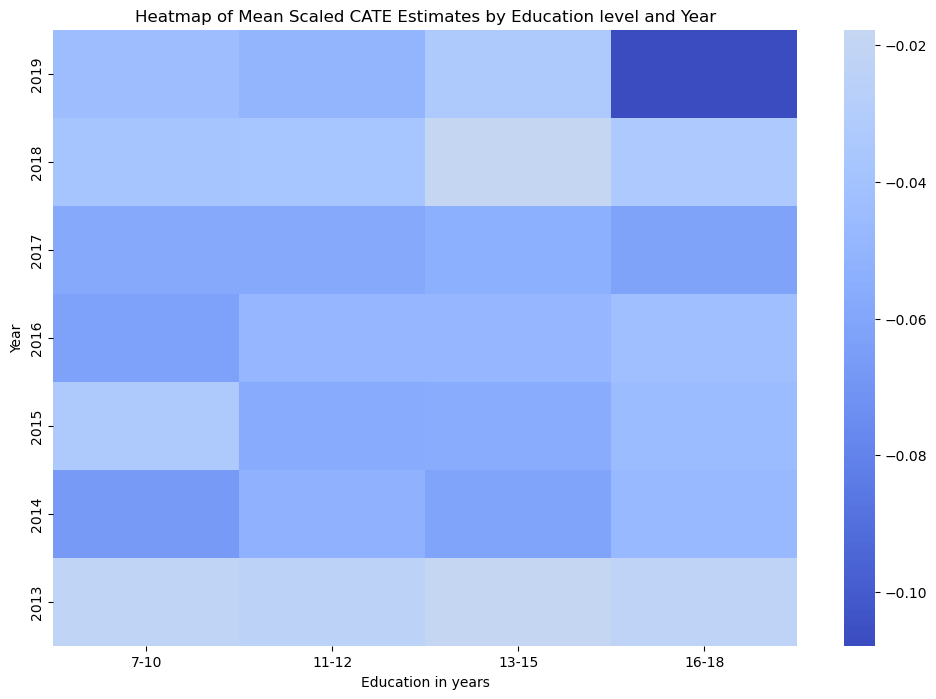

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for heatmap
heatmap_data = pd.DataFrame(cate_by_education_group_all_years).T

# Reverse the order of the rows so that the years are in increasing order on the y-axis
heatmap_data = heatmap_data[::-1]

# Plot heatmap with years increasing on the y-axis
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0)
plt.xlabel('Education in years')
plt.ylabel('Year')
plt.title('Heatmap of Mean Scaled CATE Estimates by Education level and Year')
plt.show()


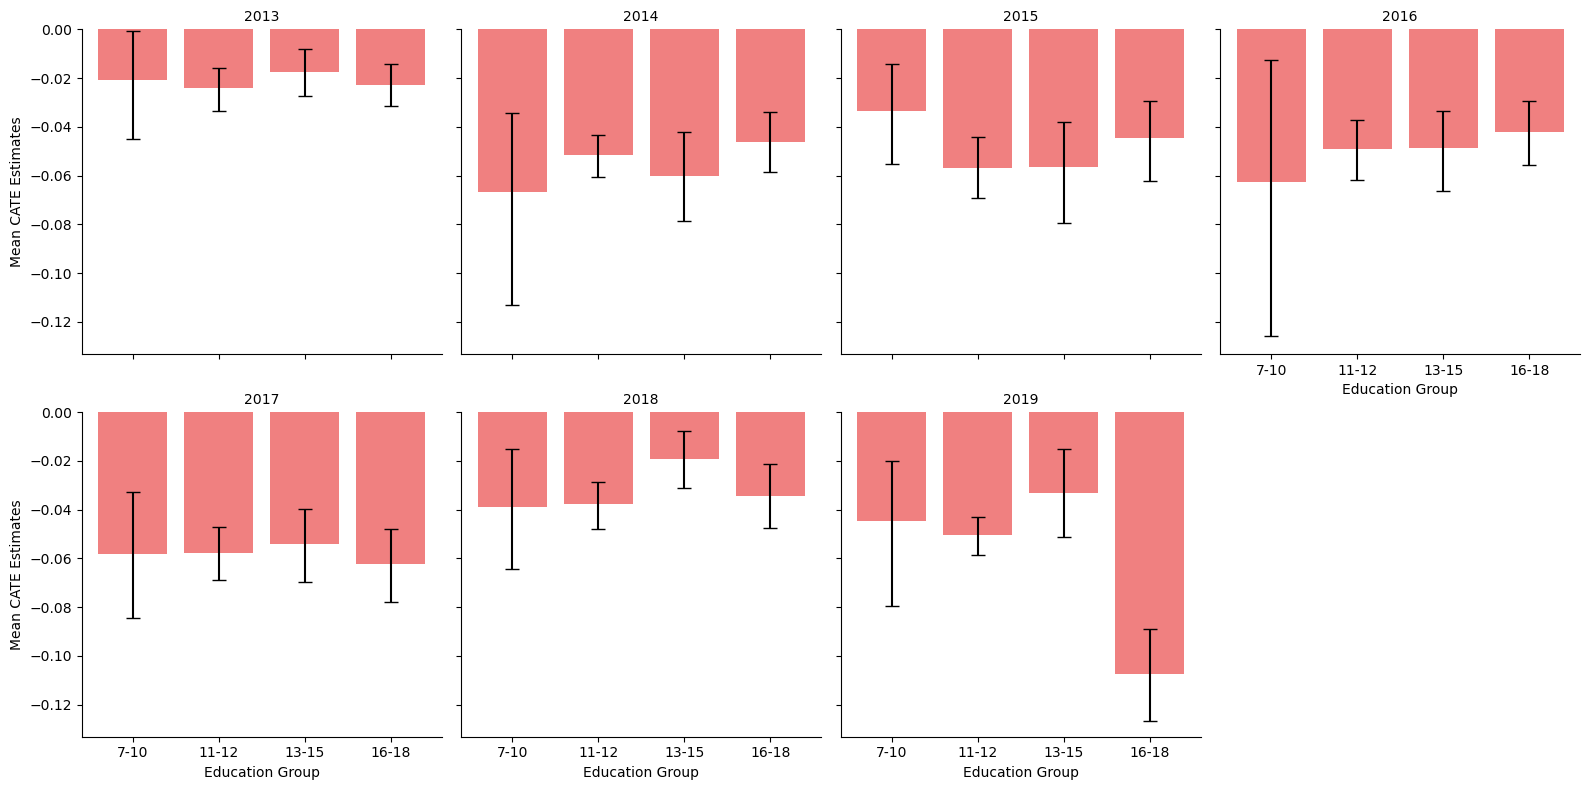

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to collect data
data_for_plotting = []

# Loop through each year and each education group to collect data
for year in years:
    for education_group in education_labels:
        mean_cate = cate_by_education_group_all_years[year][education_group]
        ci_lower = ci_lowers_by_education_group_all_years[year][education_group]
        ci_upper = ci_uppers_by_education_group_all_years[year][education_group]
        
        data_for_plotting.append({
            'Year': year,
            'Education Group': education_group,
            'CATE Estimate': mean_cate,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper
        })

# Convert the list to a DataFrame
df = pd.DataFrame(data_for_plotting)

# Ensure non-negative error values
df['CI Lower Error'] = np.abs(df['CATE Estimate'] - df['CI Lower'])
df['CI Upper Error'] = np.abs(df['CI Upper'] - df['CATE Estimate'])

# Faceted plot using Seaborn's FacetGrid
g = sns.FacetGrid(df, col="Year", col_wrap=4, height=4)
g.map(plt.bar, "Education Group", "CATE Estimate", color='lightcoral')

# Adding error bars manually
for ax, year in zip(g.axes.flat, years):
    education_groups = df[df['Year'] == year]['Education Group']
    cate_estimates = df[df['Year'] == year]['CATE Estimate']
    ci_lower_errors = df[df['Year'] == year]['CI Lower Error']
    ci_upper_errors = df[df['Year'] == year]['CI Upper Error']

    ax.errorbar(education_groups, cate_estimates, 
                yerr=[ci_lower_errors, ci_upper_errors], 
                fmt='none', capsize=5, ecolor='black')

g.set_axis_labels("Education Group", "Mean CATE Estimates")
g.set_titles(col_template="{col_name}")
plt.show()


In [10]:
import pandas as pd

# Initialize dictionaries to store standard errors and sample sizes
se_by_education_group_all_years = {year: {group: [] for group in education_labels} for year in years}
sample_size_by_education_group_all_years = {year: {group: [] for group in education_labels} for year in years}

# Update the loop to calculate standard errors and sample sizes
for year in years:
    cate_estimates_year = cate_results_scaled[year]
    pid_to_cate_map_year = dict(zip(merged_data_clean['pid'], cate_estimates_year))
    
    for education_group in education_labels:
        education_group_data = merged_data_clean[merged_data_clean['education_group'] == education_group]
        pids_in_education_group = education_group_data['pid']
        cate_estimates_for_group_year = [pid_to_cate_map_year[pid] for pid in pids_in_education_group]
        
        # Calculate mean CATE, confidence intervals, and standard error
        mean_cate_year, ci_lower_year, ci_upper_year = bootstrap_cate(cate_estimates_for_group_year)
        cate_by_education_group_all_years[year][education_group] = mean_cate_year
        ci_lowers_by_education_group_all_years[year][education_group] = ci_lower_year
        ci_uppers_by_education_group_all_years[year][education_group] = ci_upper_year
        
        # Standard error calculation
        se_year = np.std(cate_estimates_for_group_year, ddof=1) / np.sqrt(len(cate_estimates_for_group_year))
        se_by_education_group_all_years[year][education_group] = se_year
        
        # Store sample size
        sample_size_by_education_group_all_years[year][education_group] = len(cate_estimates_for_group_year)

# Prepare a DataFrame to hold the results
table_data = []

for year in years:
    for education_group in education_labels:
        table_data.append({
            'Year': year,
            'Education Group': education_group,
            'Mean CATE': cate_by_education_group_all_years[year][education_group],
            'Standard Error': se_by_education_group_all_years[year][education_group],
            'Sample Size': sample_size_by_education_group_all_years[year][education_group]
        })

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(table_data)

# Display the table
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # Format floats for readability
print(results_df)



    Year Education Group  Mean CATE  Standard Error  Sample Size
0   2013            7-10    -0.0209          0.0115          161
1   2013           11-12    -0.0241          0.0043         1261
2   2013           13-15    -0.0177          0.0051          593
3   2013           16-18    -0.0227          0.0045          802
4   2014            7-10    -0.0669          0.0205          161
5   2014           11-12    -0.0516          0.0045         1261
6   2014           13-15    -0.0602          0.0098          593
7   2014           16-18    -0.0463          0.0064          802
8   2015            7-10    -0.0336          0.0099          161
9   2015           11-12    -0.0568          0.0066         1261
10  2015           13-15    -0.0565          0.0107          593
11  2015           16-18    -0.0447          0.0078          802
12  2016            7-10    -0.0625          0.0294          161
13  2016           11-12    -0.0491          0.0060         1261
14  2016           13-15 

In [6]:
# Ensure that the 'sex' column is already correctly defined in the dataset (1 for male, 2 for female)
sex_labels = ['Male', 'Female']

# Initialize dictionaries to store the results for all years
cate_by_sex_all_years = {year: {sex: [] for sex in sex_labels} for year in years}
ci_lowers_by_sex_all_years = {year: {sex: [] for sex in sex_labels} for year in years}
ci_uppers_by_sex_all_years = {year: {sex: [] for sex in sex_labels} for year in years}


In [7]:
# Loop through each year
for year in years:
    # Extract the CATE estimates for the current year
    cate_estimates_year = cate_results_scaled[year]
    
    # Match pids with their corresponding CATE estimates for the current year
    pid_to_cate_map_year = dict(zip(merged_data_clean['pid'], cate_estimates_year))
    
    # Loop through each sex group (Male and Female) and calculate mean CATE and confidence intervals
    for sex_code, sex_label in zip([1, 2], sex_labels):
        # Filter the data for this specific sex group
        sex_group_data = merged_data_clean[merged_data_clean['sex'] == sex_code]
        
        # Get the corresponding pids for this sex group
        pids_in_sex_group = sex_group_data['pid']
        
        # Extract the CATE estimates corresponding to these pids for the current year
        cate_estimates_for_group_year = [pid_to_cate_map_year[pid] for pid in pids_in_sex_group]
        
        # Calculate the mean CATE and confidence intervals for this sex group in the current year
        mean_cate_year, ci_lower_year, ci_upper_year = bootstrap_cate(cate_estimates_for_group_year)
        cate_by_sex_all_years[year][sex_label] = mean_cate_year
        ci_lowers_by_sex_all_years[year][sex_label] = ci_lower_year
        ci_uppers_by_sex_all_years[year][sex_label] = ci_upper_year
        
        # Print the results for the current year
        print(f"Mean Scaled CATE for {sex_label} in {year}: {mean_cate_year}")
        print(f"95% Confidence Interval for {sex_label} in {year}: [{ci_lower_year}, {ci_upper_year}]")


Mean Scaled CATE for Male in 2013: -0.03167131174254116
95% Confidence Interval for Male in 2013: [-0.0380573340326578, -0.025958245337974386]
Mean Scaled CATE for Female in 2013: -0.026961494198293186
95% Confidence Interval for Female in 2013: [-0.03599473257110071, -0.018332210046881646]
Mean Scaled CATE for Male in 2014: -0.043105740808242504
95% Confidence Interval for Male in 2014: [-0.05281632022595329, -0.03347269574875328]
Mean Scaled CATE for Female in 2014: -0.03499257163378354
95% Confidence Interval for Female in 2014: [-0.04676659825939734, -0.02429333048628027]
Mean Scaled CATE for Male in 2015: -0.05175607598042549
95% Confidence Interval for Male in 2015: [-0.0624032701191215, -0.04122226447106769]
Mean Scaled CATE for Female in 2015: -0.04669124205385772
95% Confidence Interval for Female in 2015: [-0.06280380110145245, -0.03258172590097517]
Mean Scaled CATE for Male in 2016: -0.042568113555934275
95% Confidence Interval for Male in 2016: [-0.053739247175167, -0.03195

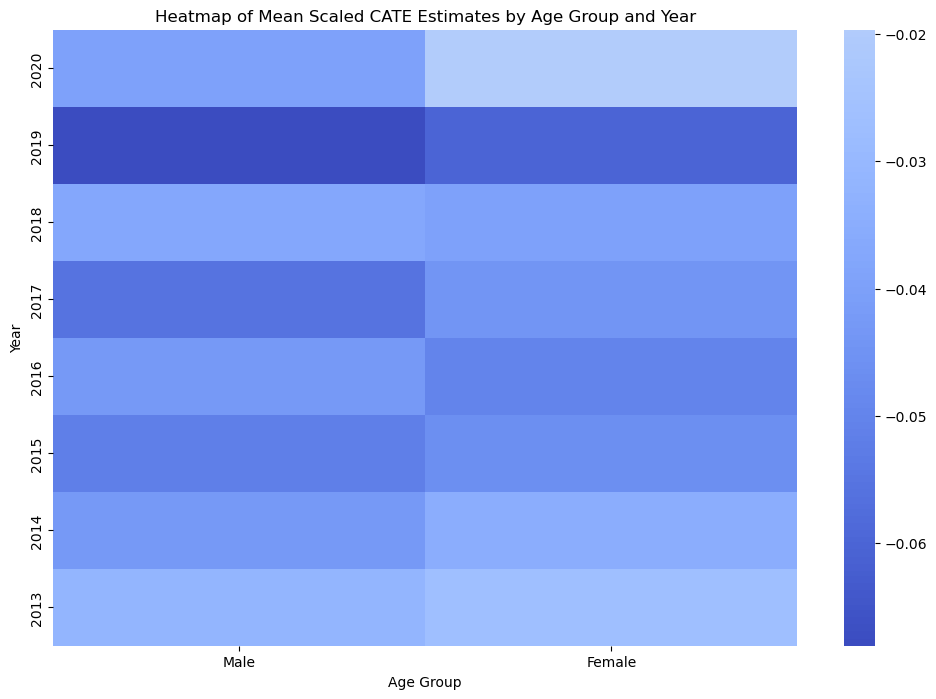

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for heatmap
heatmap_data = pd.DataFrame(cate_by_sex_all_years).T

# Reverse the order of the rows so that the years are in increasing order on the y-axis
heatmap_data = heatmap_data[::-1]

# Plot heatmap with years increasing on the y-axis
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0)
plt.xlabel('Age Group')
plt.ylabel('Year')
plt.title('Heatmap of Mean Scaled CATE Estimates by Age Group and Year')
plt.show()


In [10]:
import pandas as pd
import numpy as np

# Initialize dictionaries to store standard errors and sample sizes for sex groups
se_by_sex_all_years = {year: {sex_label: [] for sex_label in sex_labels} for year in years}
sample_size_by_sex_all_years = {year: {sex_label: [] for sex_label in sex_labels} for year in years}

# Update the loop to calculate standard errors and sample sizes for sex groups
for year in years:
    cate_estimates_year = cate_results_scaled[year]
    pid_to_cate_map_year = dict(zip(merged_data_clean['pid'], cate_estimates_year))
    
    for sex_code, sex_label in zip([1, 2], sex_labels):
        sex_group_data = merged_data_clean[merged_data_clean['sex'] == sex_code]
        pids_in_sex_group = sex_group_data['pid']
        cate_estimates_for_group_year = [pid_to_cate_map_year[pid] for pid in pids_in_sex_group]
        
        # Calculate mean CATE, confidence intervals, and standard error
        mean_cate_year, ci_lower_year, ci_upper_year = bootstrap_cate(cate_estimates_for_group_year)
        cate_by_sex_all_years[year][sex_label] = mean_cate_year
        ci_lowers_by_sex_all_years[year][sex_label] = ci_lower_year
        ci_uppers_by_sex_all_years[year][sex_label] = ci_upper_year
        
        # Standard error calculation
        se_year = np.std(cate_estimates_for_group_year, ddof=1) / np.sqrt(len(cate_estimates_for_group_year))
        se_by_sex_all_years[year][sex_label] = se_year
        
        # Store sample size
        sample_size_by_sex_all_years[year][sex_label] = len(cate_estimates_for_group_year)

# Prepare a DataFrame to hold the results for sex groups
sex_group_table_data = []

for year in years:
    for sex_label in sex_labels:
        sex_group_table_data.append({
            'Year': year,
            'Sex Group': sex_label,
            'Mean CATE': cate_by_sex_all_years[year][sex_label],
            'Standard Error': se_by_sex_all_years[year][sex_label],
            'Sample Size': sample_size_by_sex_all_years[year][sex_label]
        })

# Convert the list of dictionaries into a DataFrame
sex_group_results_df = pd.DataFrame(sex_group_table_data)

# Display the table
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # Format floats for readability
print(sex_group_results_df)


    Year Sex Group  Mean CATE  Standard Error  Sample Size
0   2013      Male    -0.0315          0.0031         1608
1   2013    Female    -0.0273          0.0046          882
2   2014      Male    -0.0432          0.0050         1608
3   2014    Female    -0.0351          0.0056          882
4   2015      Male    -0.0517          0.0051         1608
5   2015    Female    -0.0468          0.0075          882
6   2016      Male    -0.0426          0.0053         1608
7   2016    Female    -0.0502          0.0073          882
8   2017      Male    -0.0553          0.0049         1608
9   2017    Female    -0.0446          0.0044          882
10  2018      Male    -0.0373          0.0052         1608
11  2018    Female    -0.0388          0.0062          882
12  2019      Male    -0.0678          0.0062         1608
13  2019    Female    -0.0602          0.0072          882
14  2020      Male    -0.0395          0.0075         1608
15  2020    Female    -0.0196          0.0068          8

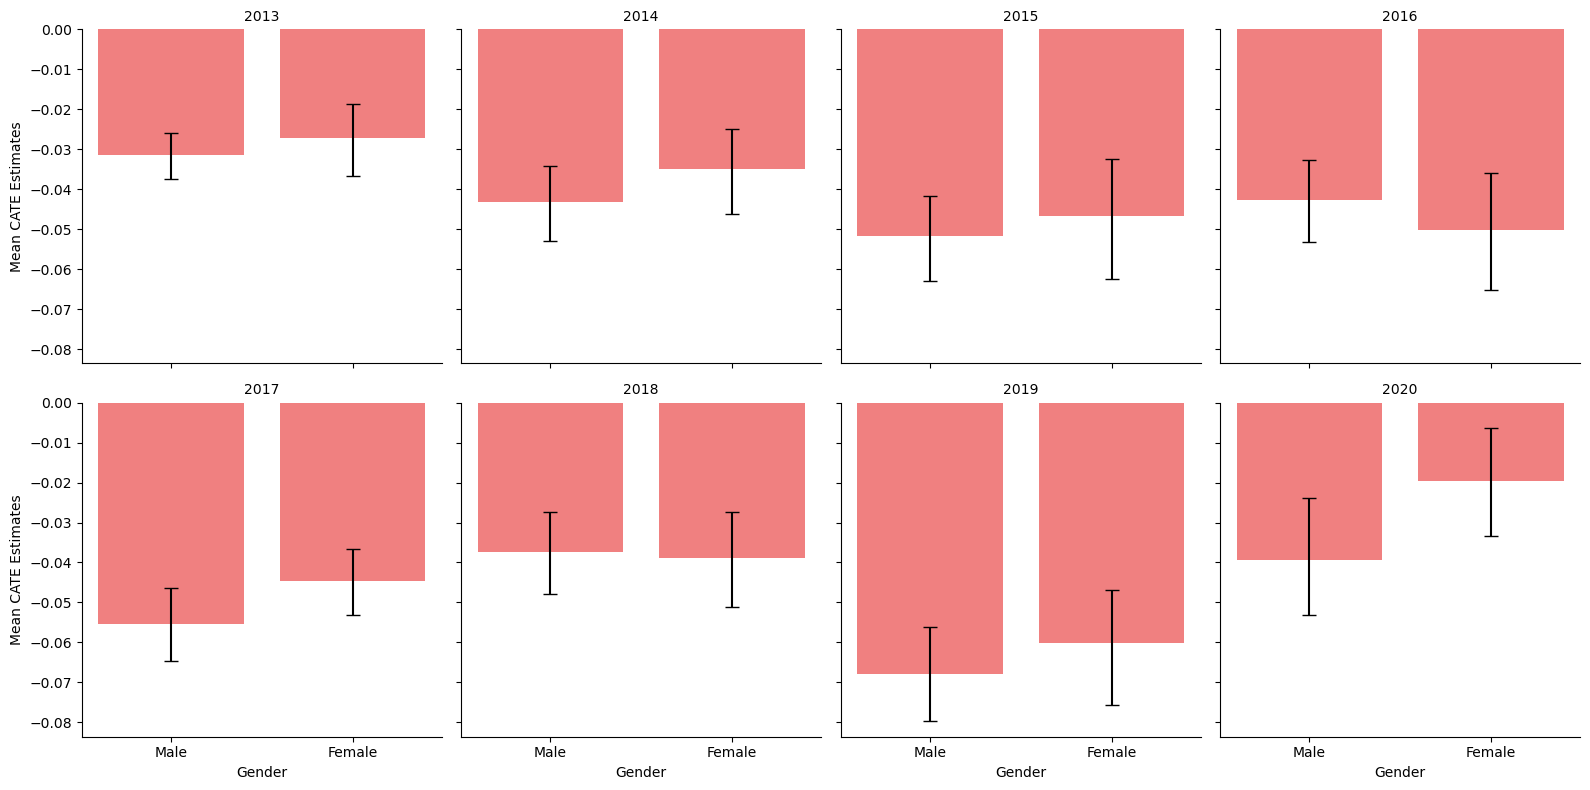

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty list to collect data
data_for_plotting_sex = []

# Loop through each year and each sex group to collect data
for year in years:
    for sex_label in sex_labels:
        mean_cate = cate_by_sex_all_years[year][sex_label]
        ci_lower = ci_lowers_by_sex_all_years[year][sex_label]
        ci_upper = ci_uppers_by_sex_all_years[year][sex_label]
        
        data_for_plotting_sex.append({
            'Year': year,
            'Sex': sex_label,
            'CATE Estimate': mean_cate,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper
        })

# Convert the list to a DataFrame
df_sex = pd.DataFrame(data_for_plotting_sex)

# Ensure non-negative error values
df_sex['CI Lower Error'] = np.abs(df_sex['CATE Estimate'] - df_sex['CI Lower'])
df_sex['CI Upper Error'] = np.abs(df_sex['CI Upper'] - df_sex['CATE Estimate'])

### Step 2: Create the Faceted Plot Using Seaborn

# Faceted plot using Seaborn's FacetGrid
g = sns.FacetGrid(df_sex, col="Year", col_wrap=4, height=4)
g.map(plt.bar, "Sex", "CATE Estimate", color='lightcoral')

# Adding error bars manually
for ax, year in zip(g.axes.flat, years):
    sex_groups = df_sex[df_sex['Year'] == year]['Sex']
    cate_estimates = df_sex[df_sex['Year'] == year]['CATE Estimate']
    ci_lower_errors = df_sex[df_sex['Year'] == year]['CI Lower Error']
    ci_upper_errors = df_sex[df_sex['Year'] == year]['CI Upper Error']

    ax.errorbar(sex_groups, cate_estimates, 
                yerr=[ci_lower_errors, ci_upper_errors], 
                fmt='none', capsize=5, ecolor='black')

g.set_axis_labels("Gender", "Mean CATE Estimates")
g.set_titles(col_template="{col_name}")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Define household size bins and labels
hhgr_bins = [0, 1, 2, 4, 12]  # Bins: 1, 2, 3-4, 5-12
hhgr_labels = ['1', '2', '3-4', '5-12']
#1, 2, 3-4, 5-12

# Add a new column for household size groups in the merged data
merged_data_clean.loc[:,'hhgr_group'] = pd.cut(merged_data_clean['hhgr'], bins=hhgr_bins, labels=hhgr_labels, right=True)


In [6]:
# Initialize dictionaries to store the results for all years
cate_by_hhgr_group_all_years = {year: {group: [] for group in hhgr_labels} for year in years}
ci_lowers_by_hhgr_group_all_years = {year: {group: [] for group in hhgr_labels} for year in years}
ci_uppers_by_hhgr_group_all_years = {year: {group: [] for group in hhgr_labels} for year in years}

# Loop through each year
for year in years:
    # Extract the CATE estimates for the current year
    cate_estimates_year = cate_results_scaled[year]
    
    # Match pids with their corresponding CATE estimates for the current year
    pid_to_cate_map_year = dict(zip(merged_data_clean['pid'], cate_estimates_year))
    
    # Loop through each household size group and calculate mean CATE and confidence intervals
    for hhgr_group in hhgr_labels:
        # Filter the data for this specific household size group
        hhgr_group_data = merged_data_clean[merged_data_clean['hhgr_group'] == hhgr_group]
        
        # Get the corresponding pids for this household size group
        pids_in_hhgr_group = hhgr_group_data['pid']
        
        # Extract the CATE estimates corresponding to these pids for the current year
        cate_estimates_for_group_year = [pid_to_cate_map_year[pid] for pid in pids_in_hhgr_group]
        
        # Calculate the mean CATE and confidence intervals for this household size group in the current year
        mean_cate_year, ci_lower_year, ci_upper_year = bootstrap_cate(cate_estimates_for_group_year)
        cate_by_hhgr_group_all_years[year][hhgr_group] = mean_cate_year
        ci_lowers_by_hhgr_group_all_years[year][hhgr_group] = ci_lower_year
        ci_uppers_by_hhgr_group_all_years[year][hhgr_group] = ci_upper_year
        
        # Print the results for the current year
        print(f"Mean Scaled CATE for Household Size Group {hhgr_group} in {year}: {mean_cate_year}")
        print(f"95% Confidence Interval for Household Size Group {hhgr_group} in {year}: [{ci_lower_year}, {ci_upper_year}]")


Mean Scaled CATE for Household Size Group 1 in 2013: -0.020419005354288373
95% Confidence Interval for Household Size Group 1 in 2013: [-0.033098608222420944, -0.009264042591817052]
Mean Scaled CATE for Household Size Group 2 in 2013: -0.03214477105323168
95% Confidence Interval for Household Size Group 2 in 2013: [-0.04294285158995078, -0.02273940456741672]
Mean Scaled CATE for Household Size Group 3-4 in 2013: -0.02778168415511589
95% Confidence Interval for Household Size Group 3-4 in 2013: [-0.034917659694950434, -0.021284327385369194]
Mean Scaled CATE for Household Size Group 5-12 in 2013: -0.04183106111052946
95% Confidence Interval for Household Size Group 5-12 in 2013: [-0.060405900520385546, -0.027082949257690395]
Mean Scaled CATE for Household Size Group 1 in 2014: -0.029434852505221352
95% Confidence Interval for Household Size Group 1 in 2014: [-0.053677357975488775, -0.0075141400569512795]
Mean Scaled CATE for Household Size Group 2 in 2014: -0.04375976534541701
95% Confid

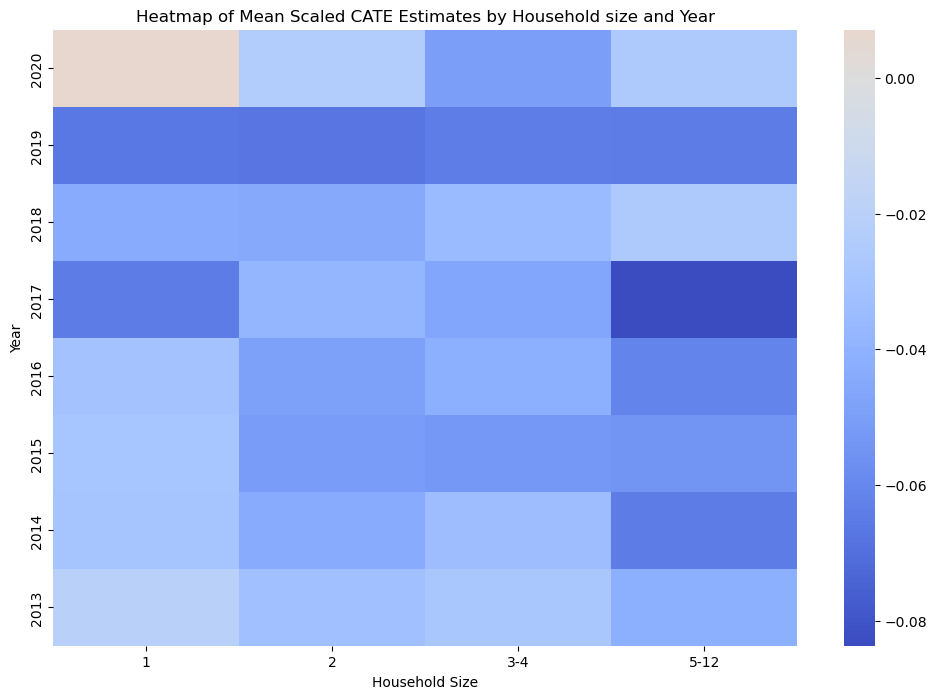

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for heatmap
heatmap_data = pd.DataFrame(cate_by_hhgr_group_all_years).T

# Reverse the order of the rows so that the years are in increasing order on the y-axis
heatmap_data = heatmap_data[::-1]

# Plot heatmap with years increasing on the y-axis
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0)
plt.xlabel('Household Size')
plt.ylabel('Year')
plt.title('Heatmap of Mean Scaled CATE Estimates by Household size and Year')
plt.show()


In [10]:
import pandas as pd
import numpy as np

# Initialize dictionaries to store standard errors and sample sizes for hhgr groups
se_by_hhgr_group_all_years = {year: {group: [] for group in hhgr_labels} for year in years}
sample_size_by_hhgr_group_all_years = {year: {group: [] for group in hhgr_labels} for year in years}

# Update the loop to calculate standard errors and sample sizes for hhgr groups
for year in years:
    cate_estimates_year = cate_results_scaled[year]
    pid_to_cate_map_year = dict(zip(merged_data_clean['pid'], cate_estimates_year))
    
    for hhgr_group in hhgr_labels:
        hhgr_group_data = merged_data_clean[merged_data_clean['hhgr_group'] == hhgr_group]
        pids_in_hhgr_group = hhgr_group_data['pid']
        cate_estimates_for_group_year = [pid_to_cate_map_year[pid] for pid in pids_in_hhgr_group]
        
        # Calculate mean CATE, confidence intervals, and standard error
        mean_cate_year, ci_lower_year, ci_upper_year = bootstrap_cate(cate_estimates_for_group_year)
        cate_by_hhgr_group_all_years[year][hhgr_group] = mean_cate_year
        ci_lowers_by_hhgr_group_all_years[year][hhgr_group] = ci_lower_year
        ci_uppers_by_hhgr_group_all_years[year][hhgr_group] = ci_upper_year
        
        # Standard error calculation
        se_year = np.std(cate_estimates_for_group_year, ddof=1) / np.sqrt(len(cate_estimates_for_group_year))
        se_by_hhgr_group_all_years[year][hhgr_group] = se_year
        
        # Store sample size
        sample_size_by_hhgr_group_all_years[year][hhgr_group] = len(cate_estimates_for_group_year)

# Prepare a DataFrame to hold the results for hhgr groups
hhgr_group_table_data = []

for year in years:
    for hhgr_group in hhgr_labels:
        hhgr_group_table_data.append({
            'Year': year,
            'HHGR Group': hhgr_group,
            'Mean CATE': cate_by_hhgr_group_all_years[year][hhgr_group],
            'Standard Error': se_by_hhgr_group_all_years[year][hhgr_group],
            'Sample Size': sample_size_by_hhgr_group_all_years[year][hhgr_group]
        })

# Convert the list of dictionaries into a DataFrame
hhgr_group_results_df = pd.DataFrame(hhgr_group_table_data)

# Display the table
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # Format floats for readability
print(hhgr_group_results_df)


    Year HHGR Group  Mean CATE  Standard Error  Sample Size
0   2013          1    -0.0205          0.0060          310
1   2013          2    -0.0321          0.0053          699
2   2013        3-4    -0.0277          0.0034         1136
3   2013       5-12    -0.0414          0.0088          345
4   2014          1    -0.0295          0.0124          310
5   2014          2    -0.0443          0.0070          699
6   2014        3-4    -0.0341          0.0055         1136
7   2014       5-12    -0.0642          0.0102          345
8   2015          1    -0.0286          0.0082          310
9   2015          2    -0.0512          0.0086          699
10  2015        3-4    -0.0531          0.0067         1136
11  2015       5-12    -0.0546          0.0099          345
12  2016          1    -0.0315          0.0087          310
13  2016          2    -0.0482          0.0085          699
14  2016        3-4    -0.0416          0.0065         1136
15  2016       5-12    -0.0617          

In [11]:
from IPython.display import display, HTML
display(HTML(hhgr_group_results_df.to_html()))


,Year,HHGR Group,Mean CATE,Standard Error,Sample Size
0,2013,1,-0.0205,0.0060,310
1,2013,2,-0.0321,0.0053,699
2,2013,3-4,-0.0277,0.0034,1136
3,2013,5-12,-0.0414,0.0088,345
4,2014,1,-0.0295,0.0124,310
5,2014,2,-0.0443,0.0070,699
6,2014,3-4,-0.0341,0.0055,1136
7,2014,5-12,-0.0642,0.0102,345
8,2015,1,-0.0286,0.0082,310
9,2015,2,-0.0512,0.0086,699


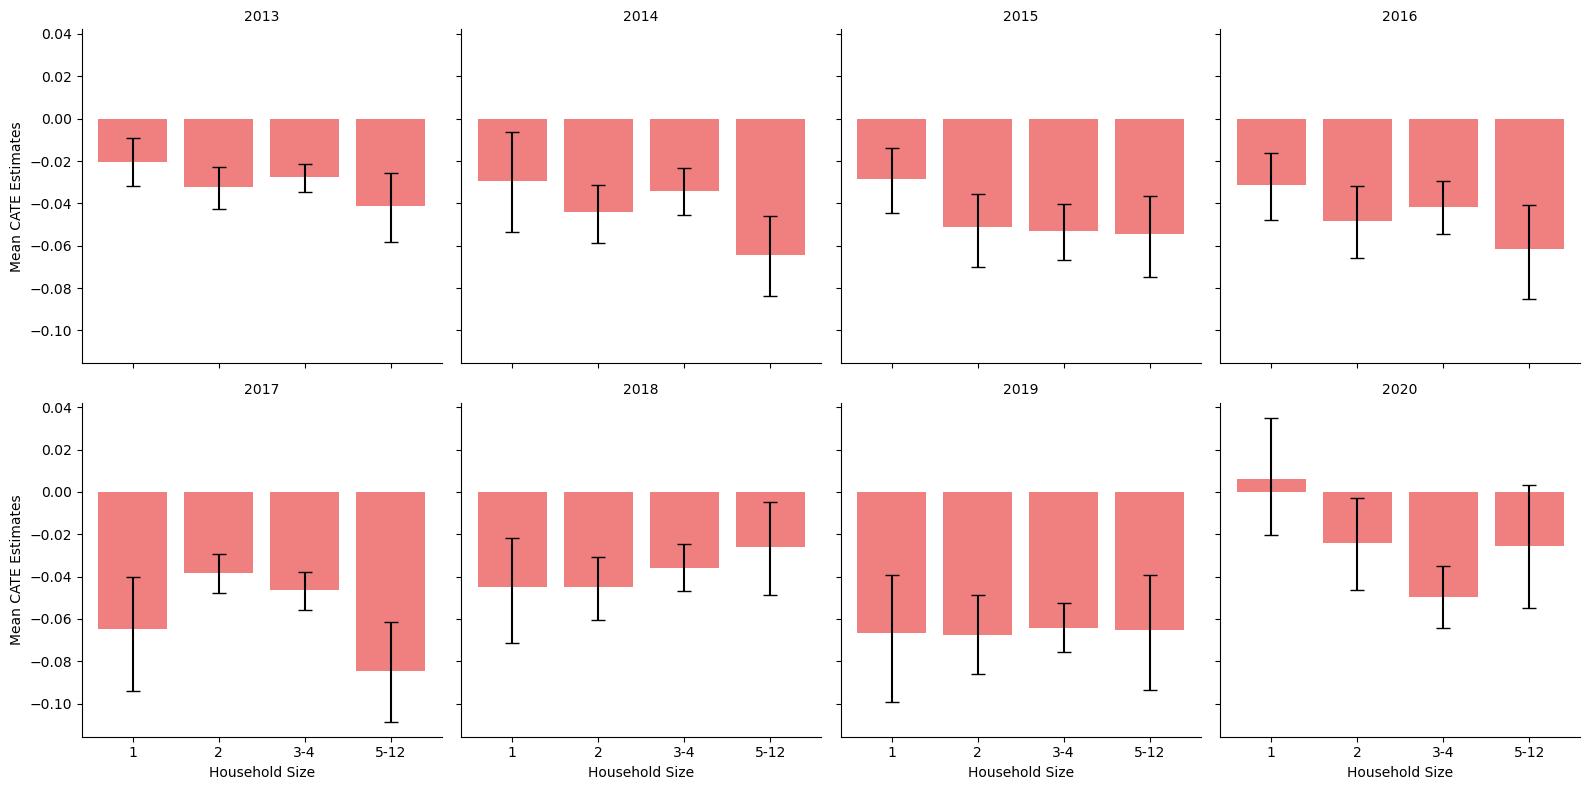

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to collect data
data_for_plotting = []

# Loop through each year and each household size group to collect data
for year in years:
    for hhgr_group in hhgr_labels:
        mean_cate = cate_by_hhgr_group_all_years[year][hhgr_group]
        ci_lower = ci_lowers_by_hhgr_group_all_years[year][hhgr_group]
        ci_upper = ci_uppers_by_hhgr_group_all_years[year][hhgr_group]
        
        data_for_plotting.append({
            'Year': year,
            'Household Size Group': hhgr_group,
            'CATE Estimate': mean_cate,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper
        })

# Convert the list to a DataFrame
df = pd.DataFrame(data_for_plotting)

# Ensure non-negative error values
df['CI Lower Error'] = np.abs(df['CATE Estimate'] - df['CI Lower'])
df['CI Upper Error'] = np.abs(df['CI Upper'] - df['CATE Estimate'])

# Faceted plot using Seaborn's FacetGrid
g = sns.FacetGrid(df, col="Year", col_wrap=4, height=4)
g.map(plt.bar, "Household Size Group", "CATE Estimate", color='lightcoral')

# Adding error bars manually
for ax, year in zip(g.axes.flat, years):
    household_groups = df[df['Year'] == year]['Household Size Group']
    cate_estimates = df[df['Year'] == year]['CATE Estimate']
    ci_lower_errors = df[df['Year'] == year]['CI Lower Error']
    ci_upper_errors = df[df['Year'] == year]['CI Upper Error']

    ax.errorbar(household_groups, cate_estimates, 
                yerr=[ci_lower_errors, ci_upper_errors], 
                fmt='none', capsize=5, ecolor='black')

g.set_axis_labels("Household Size", "Mean CATE Estimates")
g.set_titles(col_template="{col_name}")
plt.show()


In [7]:
# Define age bins and labels
age_bins = [18, 25, 35, 45, 55, 66]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-66']

# Add a new column for age groups in the 2013 data
merged_data_clean.loc[:,'age_group'] = pd.cut(merged_data_clean['age_at_survey'], bins=age_bins, labels=age_labels, right=False)

In [11]:
# Define the range of years you want to analyze
years_to_analyze = range(2013, 2020)

# Initialize dictionaries to store the results for all years
cate_by_age_group_all_years = {year: {age_group: [] for age_group in age_labels} for year in years_to_analyze}
ci_lowers_by_age_group_all_years = {year: {age_group: [] for age_group in age_labels} for year in years_to_analyze}
ci_uppers_by_age_group_all_years = {year: {age_group: [] for age_group in age_labels} for year in years_to_analyze}

# Loop through each year
for year in years_to_analyze:
    # Extract the CATE estimates for the current year
    cate_estimates_year = cate_results_scaled[year]
    
    # Match pids with their corresponding CATE estimates for the current year
    pid_to_cate_map_year = dict(zip(merged_data_clean['pid'], cate_estimates_year))
    
    # Loop through each age group and calculate mean CATE and confidence intervals
    for age_group in age_labels:
        # Filter the data for this specific age group
        age_group_data = merged_data_clean[merged_data_clean['age_group'] == age_group]
        
        # Get the corresponding pids for this age group
        pids_in_age_group = age_group_data['pid']
        
        # Extract the CATE estimates corresponding to these pids for the current year
        cate_estimates_for_group_year = [pid_to_cate_map_year[pid] for pid in pids_in_age_group]
        
        # Calculate the mean CATE and confidence intervals for this age group in the current year
        mean_cate_year, ci_lower_year, ci_upper_year = bootstrap_cate(cate_estimates_for_group_year)
        cate_by_age_group_all_years[year][age_group] = mean_cate_year
        ci_lowers_by_age_group_all_years[year][age_group] = ci_lower_year
        ci_uppers_by_age_group_all_years[year][age_group] = ci_upper_year
        
        # Print the results for the current year
        print(f"Mean Scaled CATE for Age Group {age_group} in {year}: {mean_cate_year}")
        print(f"95% Confidence Interval for Age Group {age_group} in {year}: [{ci_lower_year}, {ci_upper_year}]")


Mean Scaled CATE for Age Group 18-25 in 2013: -0.019214685001162805
95% Confidence Interval for Age Group 18-25 in 2013: [-0.03744987085956072, -0.0026053650197782976]
Mean Scaled CATE for Age Group 26-35 in 2013: -0.019249694401970656
95% Confidence Interval for Age Group 26-35 in 2013: [-0.028808672881752904, -0.00965449437316121]
Mean Scaled CATE for Age Group 36-45 in 2013: -0.03040214885382381
95% Confidence Interval for Age Group 36-45 in 2013: [-0.03983395852777484, -0.022287038861773537]
Mean Scaled CATE for Age Group 46-55 in 2013: -0.036259099350123836
95% Confidence Interval for Age Group 46-55 in 2013: [-0.045835440745637425, -0.02756852283367654]
Mean Scaled CATE for Age Group 56-66 in 2013: -0.03344305112930689
95% Confidence Interval for Age Group 56-66 in 2013: [-0.05359251074953995, -0.015272814573617413]
Mean Scaled CATE for Age Group 18-25 in 2014: -0.03408912893048436
95% Confidence Interval for Age Group 18-25 in 2014: [-0.04904623894639153, -0.02110765193153522]
M

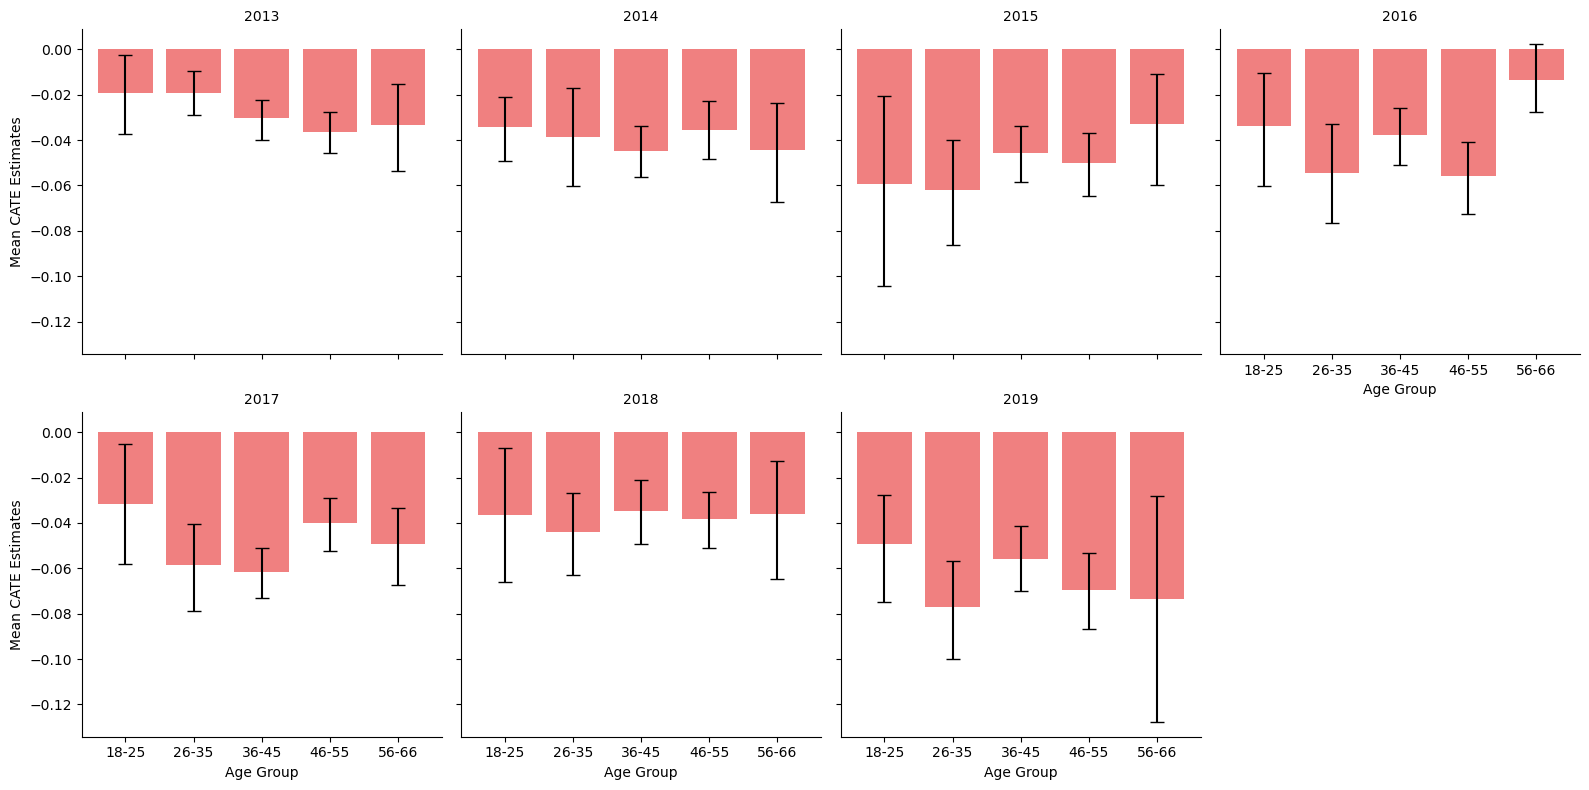

In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to collect data
data_for_plotting = []

# Loop through each year and each age group to collect data
for year in years:
    for age_group in age_labels:
        mean_cate = cate_by_age_group_all_years[year][age_group]
        ci_lower = ci_lowers_by_age_group_all_years[year][age_group]
        ci_upper = ci_uppers_by_age_group_all_years[year][age_group]
        
        data_for_plotting.append({
            'Year': year,
            'Age Group': age_group,
            'CATE Estimate': mean_cate,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper
        })

# Convert the list to a DataFrame
df = pd.DataFrame(data_for_plotting)

# Ensure non-negative error values
df['CI Lower Error'] = np.abs(df['CATE Estimate'] - df['CI Lower'])
df['CI Upper Error'] = np.abs(df['CI Upper'] - df['CATE Estimate'])

# Faceted plot using Seaborn's FacetGrid
g = sns.FacetGrid(df, col="Year", col_wrap=4, height=4)
g.map(plt.bar, "Age Group", "CATE Estimate", color='lightcoral')

# Adding error bars manually
for ax, year in zip(g.axes.flat, years):
    age_groups = df[df['Year'] == year]['Age Group']
    cate_estimates = df[df['Year'] == year]['CATE Estimate']
    ci_lower_errors = df[df['Year'] == year]['CI Lower Error']
    ci_upper_errors = df[df['Year'] == year]['CI Upper Error']

    ax.errorbar(age_groups, cate_estimates, 
                yerr=[ci_lower_errors, ci_upper_errors], 
                fmt='none', capsize=5, ecolor='black')

g.set_axis_labels("Age Group", "Mean CATE Estimates")
g.set_titles(col_template="{col_name}")
plt.show()


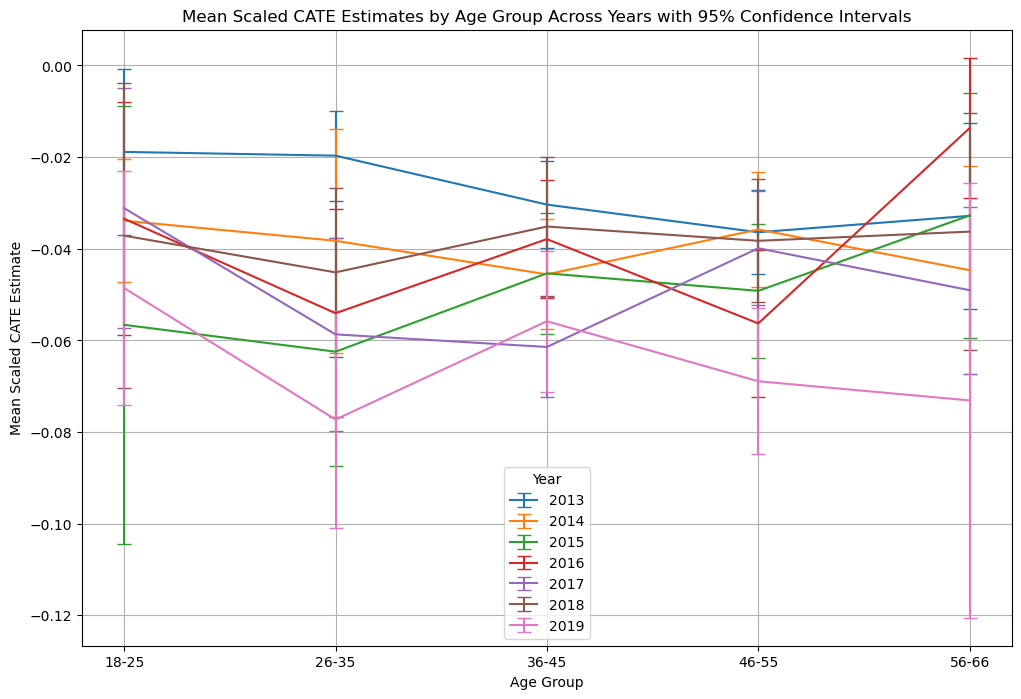

In [13]:
plt.figure(figsize=(12, 8))

# Loop through each year to plot on the same figure
for year in years_to_analyze:
    plt.errorbar(cate_by_age_group_all_years[year].keys(), 
                 cate_by_age_group_all_years[year].values(), 
                 yerr=[cate_by_age_group_all_years[year][key] - ci_lowers_by_age_group_all_years[year][key] for key in age_labels], 
                 capsize=5, label=f'{year}')
    
plt.xlabel('Age Group')
plt.ylabel('Mean Scaled CATE Estimate')
plt.title('Mean Scaled CATE Estimates by Age Group Across Years with 95% Confidence Intervals')
plt.legend(title="Year")
plt.grid(True)
plt.show()


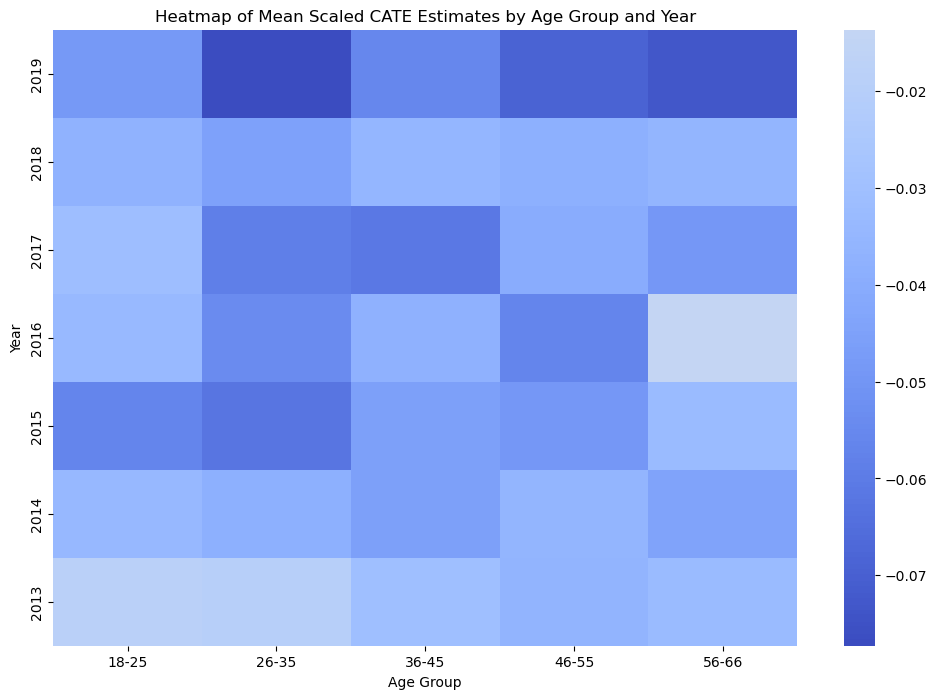

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for heatmap
heatmap_data = pd.DataFrame(cate_by_age_group_all_years).T

# Reverse the order of the rows so that the years are in increasing order on the y-axis
heatmap_data = heatmap_data[::-1]

# Plot heatmap with years increasing on the y-axis
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0)
plt.xlabel('Age Group')
plt.ylabel('Year')
plt.title('Heatmap of Mean Scaled CATE Estimates by Age Group and Year')
plt.show()


In [16]:
import pandas as pd
import numpy as np

# Initialize dictionaries to store standard errors and sample sizes for age groups
se_by_age_group_all_years = {year: {age_group: [] for age_group in age_labels} for year in years_to_analyze}
sample_size_by_age_group_all_years = {year: {age_group: [] for age_group in age_labels} for year in years_to_analyze}

# Update the loop to calculate standard errors and sample sizes for age groups
for year in years_to_analyze:
    cate_estimates_year = cate_results_scaled[year]
    pid_to_cate_map_year = dict(zip(merged_data_clean['pid'], cate_estimates_year))
    
    for age_group in age_labels:
        age_group_data = merged_data_clean[merged_data_clean['age_group'] == age_group]
        pids_in_age_group = age_group_data['pid']
        cate_estimates_for_group_year = [pid_to_cate_map_year[pid] for pid in pids_in_age_group]
        
        # Calculate mean CATE, confidence intervals, and standard error
        mean_cate_year, ci_lower_year, ci_upper_year = bootstrap_cate(cate_estimates_for_group_year)
        cate_by_age_group_all_years[year][age_group] = mean_cate_year
        ci_lowers_by_age_group_all_years[year][age_group] = ci_lower_year
        ci_uppers_by_age_group_all_years[year][age_group] = ci_upper_year
        
        # Standard error calculation
        se_year = np.std(cate_estimates_for_group_year, ddof=1) / np.sqrt(len(cate_estimates_for_group_year))
        se_by_age_group_all_years[year][age_group] = se_year
        
        # Store sample size
        sample_size_by_age_group_all_years[year][age_group] = len(cate_estimates_for_group_year)

# Prepare a DataFrame to hold the results for age groups
age_group_table_data = []

for year in years_to_analyze:
    for age_group in age_labels:
        age_group_table_data.append({
            'Year': year,
            'Age Group': age_group,
            'Mean CATE': cate_by_age_group_all_years[year][age_group],
            'Standard Error': se_by_age_group_all_years[year][age_group],
            'Sample Size': sample_size_by_age_group_all_years[year][age_group]
        })

# Convert the list of dictionaries into a DataFrame
age_group_results_df = pd.DataFrame(age_group_table_data)

# Display the table
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # Format floats for readability
print(age_group_results_df)


    Year Age Group  Mean CATE  Standard Error  Sample Size
0   2013     18-25    -0.0189          0.0089          115
1   2013     26-35    -0.0197          0.0048          469
2   2013     36-45    -0.0305          0.0045          902
3   2013     46-55    -0.0367          0.0047          834
4   2013     56-66    -0.0330          0.0101          170
5   2014     18-25    -0.0338          0.0070          115
6   2014     26-35    -0.0388          0.0113          469
7   2014     36-45    -0.0456          0.0060          902
8   2014     46-55    -0.0360          0.0063          834
9   2014     56-66    -0.0444          0.0113          170
10  2015     18-25    -0.0586          0.0221          115
11  2015     26-35    -0.0630          0.0118          469
12  2015     36-45    -0.0457          0.0066          902
13  2015     46-55    -0.0499          0.0071          834
14  2015     56-66    -0.0329          0.0125          170
15  2016     18-25    -0.0338          0.0126          1

In [17]:
from IPython.display import display, HTML
display(HTML(age_group_results_df.to_html()))

,Year,Age Group,Mean CATE,Standard Error,Sample Size
0,2013,18-25,-0.0189,0.0089,115
1,2013,26-35,-0.0197,0.0048,469
2,2013,36-45,-0.0305,0.0045,902
3,2013,46-55,-0.0367,0.0047,834
4,2013,56-66,-0.0330,0.0101,170
5,2014,18-25,-0.0338,0.0070,115
6,2014,26-35,-0.0388,0.0113,469
7,2014,36-45,-0.0456,0.0060,902
8,2014,46-55,-0.0360,0.0063,834
9,2014,56-66,-0.0444,0.0113,170
